In [885]:
import pyaudio
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import librosa
import os
import pandas as pd
import sounddevice as sd
from scipy.signal import chirp
import threading
import time
from matplotlib import cm
from matplotlib.colors import Normalize

In [811]:
CHANNELS = 1
SR = 48000 # Sample rate in Hz
FORMAT = pyaudio.paFloat32  # 16-bit audio format
AMPLIFICATION_FACTOR = 10**(47 / 20)  # Convert 47 dB to linear scale
CHUNK = 1024# 4096*4 # Number of frames per buffer

In [812]:
SOUNDS = {
    "sweep": chirp(np.linspace(0, 1, SR), f0=100, f1=10000, t1=1, method='linear').astype('float32'),
    "white_noise": np.random.uniform(low=-0.999, high=1.0, size=(SR)).astype('float32'),
    "silence": np.zeros((SR,), dtype='float32'),
}

In [813]:
init_dur = 0.01  # Duration in seconds
init_freq = 2000  # Frequency of the tone in Hz
t = np.linspace(0, init_dur, int(SR * init_dur), endpoint=False)

init_tone = np.sin(2 * np.pi * init_freq * t).astype('float32')
init_pad1 = np.zeros((24000,), dtype='float32')
init_pad2 = np.zeros((1000,), dtype='float32')

# plt.figure(figsize=(30, 5))
# plt.plot(init_tone)

In [814]:
duration = 2  # Duration in seconds
frequency1 = 100  # Frequency of the tone in Hz
frequency2 = 5000  # Frequency of the tone in Hz

# Generate time vector
t = np.linspace(0, duration, int(SR * duration), endpoint=False)

# Generate the sinusoidal tone
tone1 = np.sin(2 * np.pi * frequency1 * t).astype('float32')
tone2 = np.sin(2 * np.pi * frequency2 * t).astype('float32')
# sound = np.hstack([init_tone, tone1, tone2, init_tone])
sound = np.hstack([init_pad1, init_tone, init_pad2, tone1, init_pad2, init_tone, init_pad1])

In [815]:
audio = pyaudio.PyAudio()
input_device_index = None
output_device_index = None

for i in range(audio.get_device_count()):
    device_info = audio.get_device_info_by_index(i)
    
    if (not input_device_index and "MAYA44USB" in device_info['name'] and "Ch12" in device_info['name'] and 
        device_info['maxInputChannels'] == 4):
        input_device_index = i
    if (not output_device_index and "MAYA44USB" in device_info['name'] and "Ch12" in device_info['name'] and 
        device_info['maxOutputChannels'] == 4):
        output_device_index = i
audio = pyaudio.PyAudio()
stream = audio.open(
    format=FORMAT,      #? they used paInt32 in the paper
    channels=CHANNELS,
    rate=SR,
    output=True,
    input=True,
    input_device_index=input_device_index,
    frames_per_buffer=CHUNK,
    output_device_index=output_device_index
)

global Ains
Ains = np.zeros_like(sound, dtype=np.float32)

start_event = threading.Event()

def playback():
    start_event.wait()
    stream.write(sound.tobytes())

def recording():
    global Ains
    frames = []
    start_event.wait()
    num_frames = int(len(sound) / CHUNK)
    for _ in range(num_frames):
        data = stream.read(CHUNK, exception_on_overflow=False)
        frames.append(np.frombuffer(data, dtype=np.float32))
    Ains = np.hstack(frames)

# Create threads
play_thread = threading.Thread(target=playback)
record_thread = threading.Thread(target=recording)

play_thread.start()
record_thread.start()

start_event.set()

play_thread.join()
record_thread.join()

stream.stop_stream()
stream.close()
audio.terminate()



In [816]:
Ains_norm = Ains / np.max(np.abs(Ains))

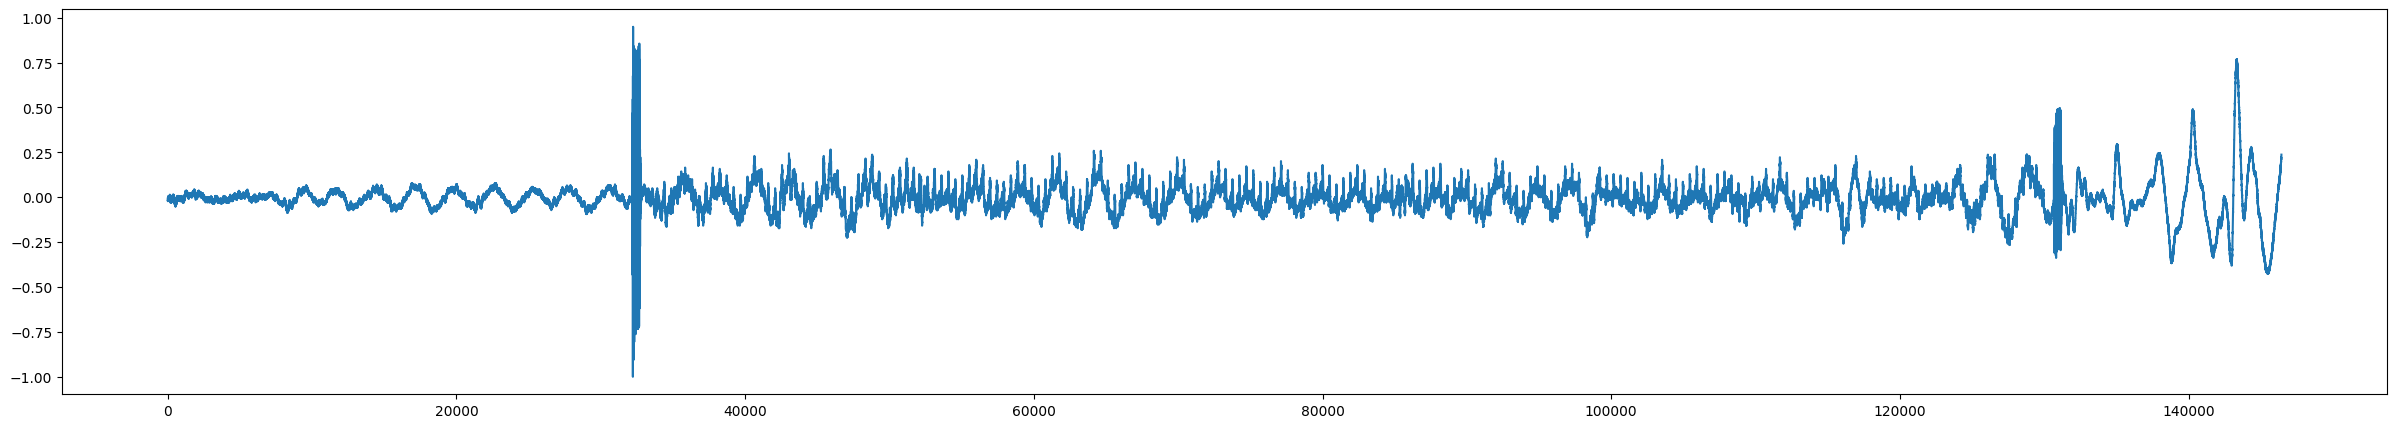

In [817]:
plt.figure(figsize=(30, 5))
plt.plot(Ains_norm)

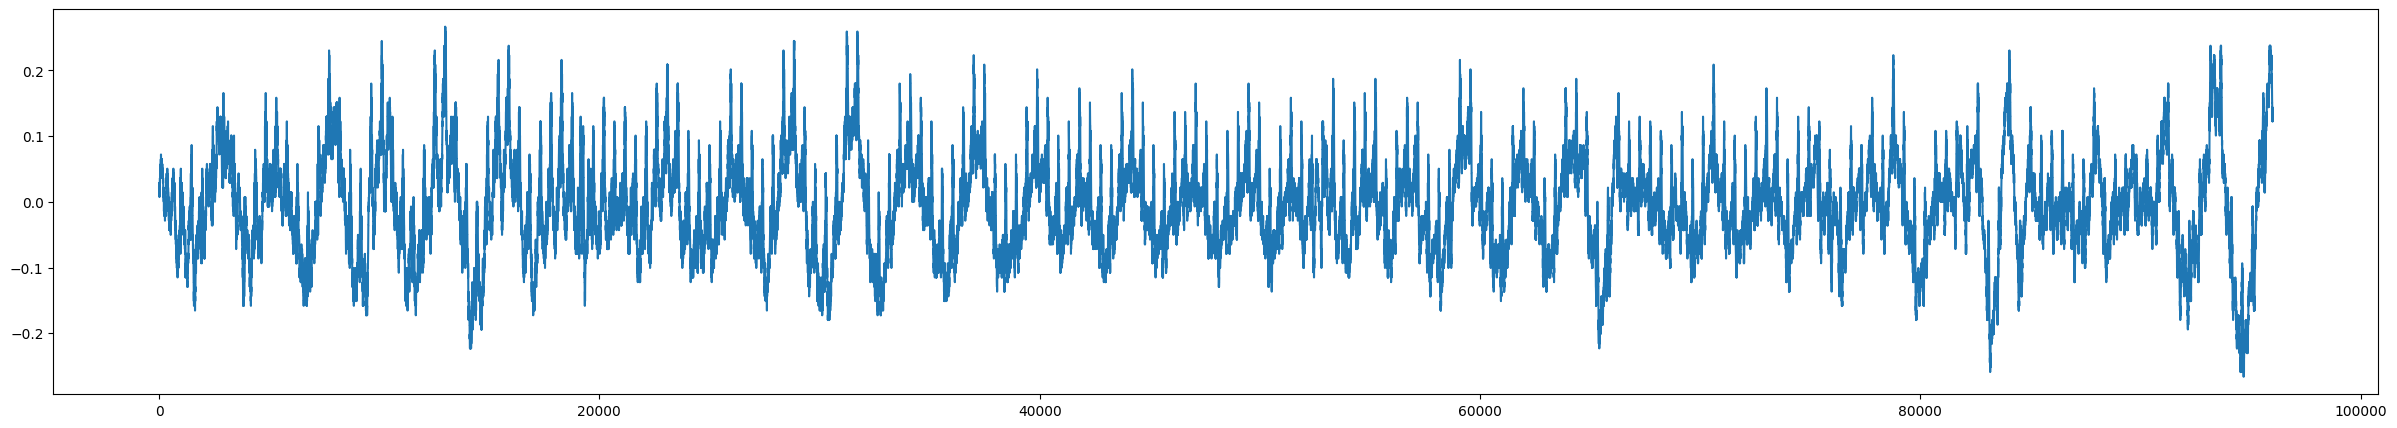

In [818]:
sample_window_size = len(tone1)
sample_begin = Ains_norm.argmax() + len(init_tone) + 200

bend = "full_range_close"
id = 5
sample = Ains_norm[sample_begin:(sample_begin+sample_window_size)]
sample_df = pd.DataFrame(sample, columns=["Amplitude"])
sample_df.to_csv(f"samples/sample_{frequency1}Hz_{bend}_{id}.csv", index=False)
plt.figure(figsize=(30, 5))
plt.plot(sample)

In [820]:
samples_closing = []
# samples_opening = []

for i in range(0, 6):
    # sample_df = pd.read_csv(f"samples/sample_{frequency1}Hz_full_range_open_{i}.csv")
    # samples_opening.append(sample_df["Amplitude"].values)
    sample_df = pd.read_csv(f"samples/sample_{frequency1}Hz_full_range_close_{i}.csv")
    samples_closing.append(sample_df["Amplitude"].values)

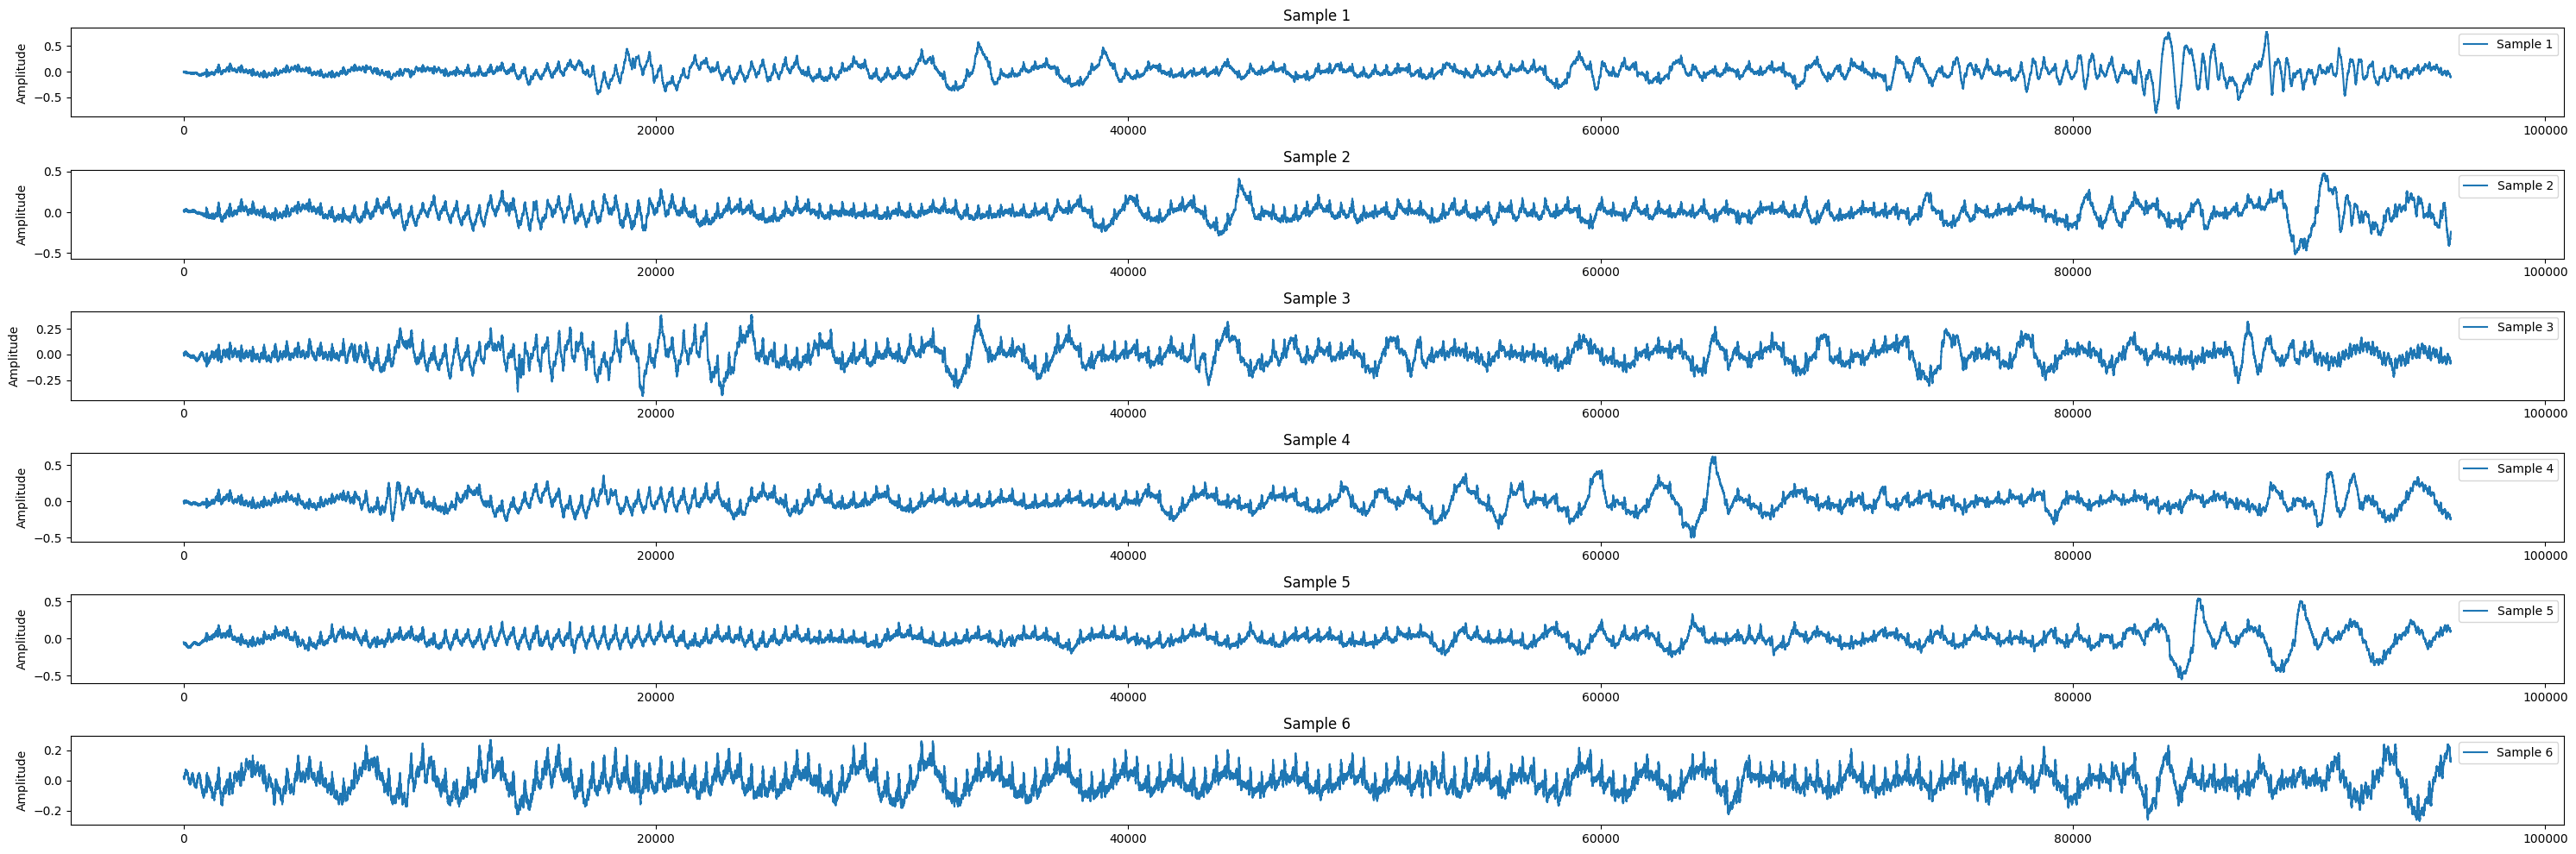

In [957]:
plt.figure(figsize=(30, 10))
for idx, sample in enumerate(samples_closing):
    plt.subplot(len(samples_closing), 1, idx + 1)
    plt.plot(sample, label=f'Sample {idx+1}')
    plt.title(f'Sample {idx+1}')
    plt.ylabel('Amplitude')
    plt.legend()
plt.tight_layout()
plt.show()

data from ~2seconds of inflating the fingertip chamber

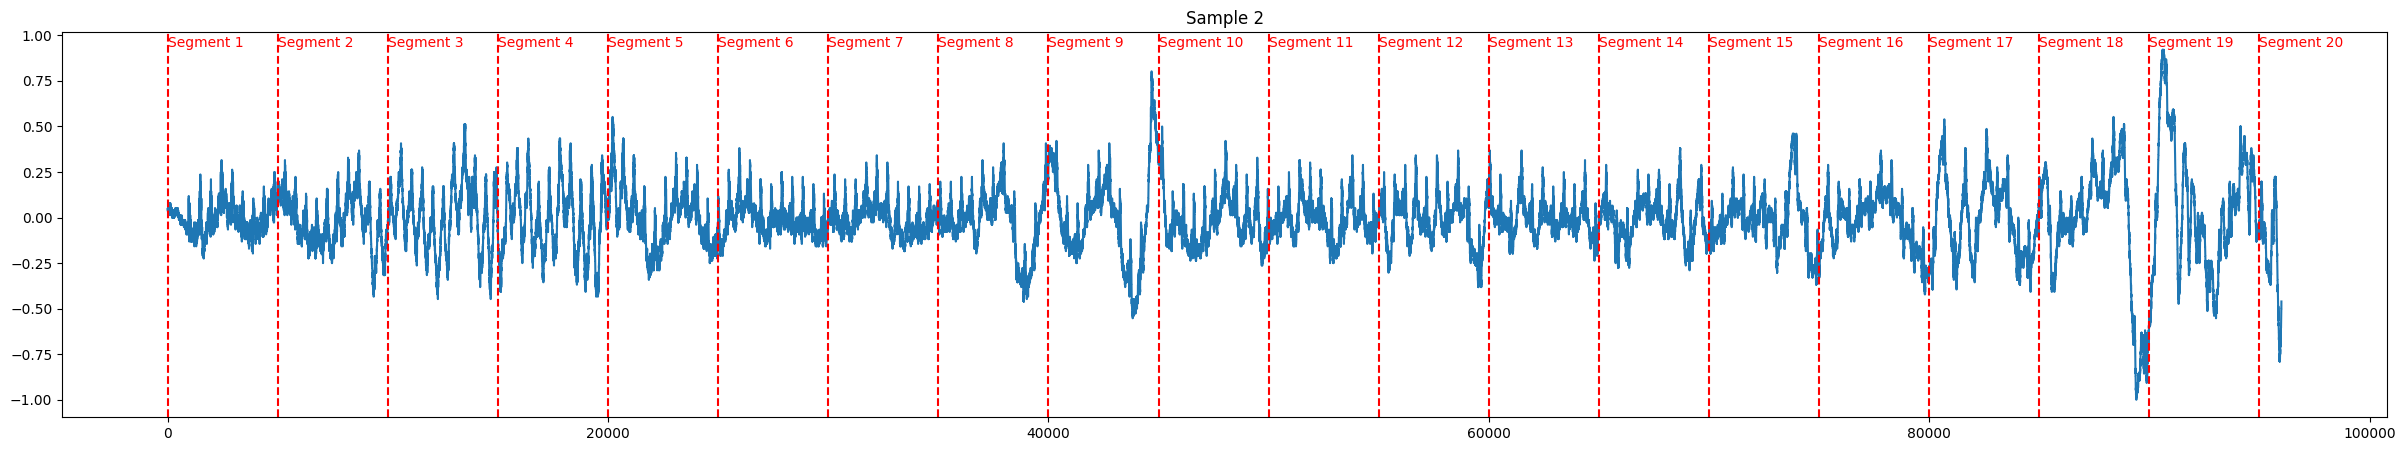

In [994]:
segment_size = 5000
sample_closing_0 = samples_closing[1]

sample_closing_0 = sample_closing_0 / np.max(np.abs(sample_closing_0)) #! normalization

num_segments = (len(sample_closing_0) // segment_size)+1

segments_sample_closing_0_spectra = []

for i in range(num_segments):
    segment = sample_closing_0[i*segment_size:(i+1)*segment_size]
    segment_spectrum = np.fft.rfft(segment)
    segment_amplitude = np.abs(segment_spectrum)
    segment_phase = np.angle(segment_spectrum)
    segment_frequency = np.fft.rfftfreq(len(segment), 1/SR)
    segment_series = pd.DataFrame({
        "Amplitude": segment_amplitude,
        "Phase": segment_phase
    }, index=pd.Index(segment_frequency, name="Frequency"))
    segments_sample_closing_0_spectra.append(segment_series)

plt.figure(figsize=(30, 5))
plt.plot(sample_closing_0)
plt.title(f'Sample 2')
for xc in range(0, len(sample_closing_0), segment_size):
    plt.axvline(x=xc, color='r', linestyle='--')
    plt.text(xc, max(sample_closing_0), f'Segment {xc // segment_size + 1}', rotation=0, verticalalignment='bottom', color='r')
plt.show()

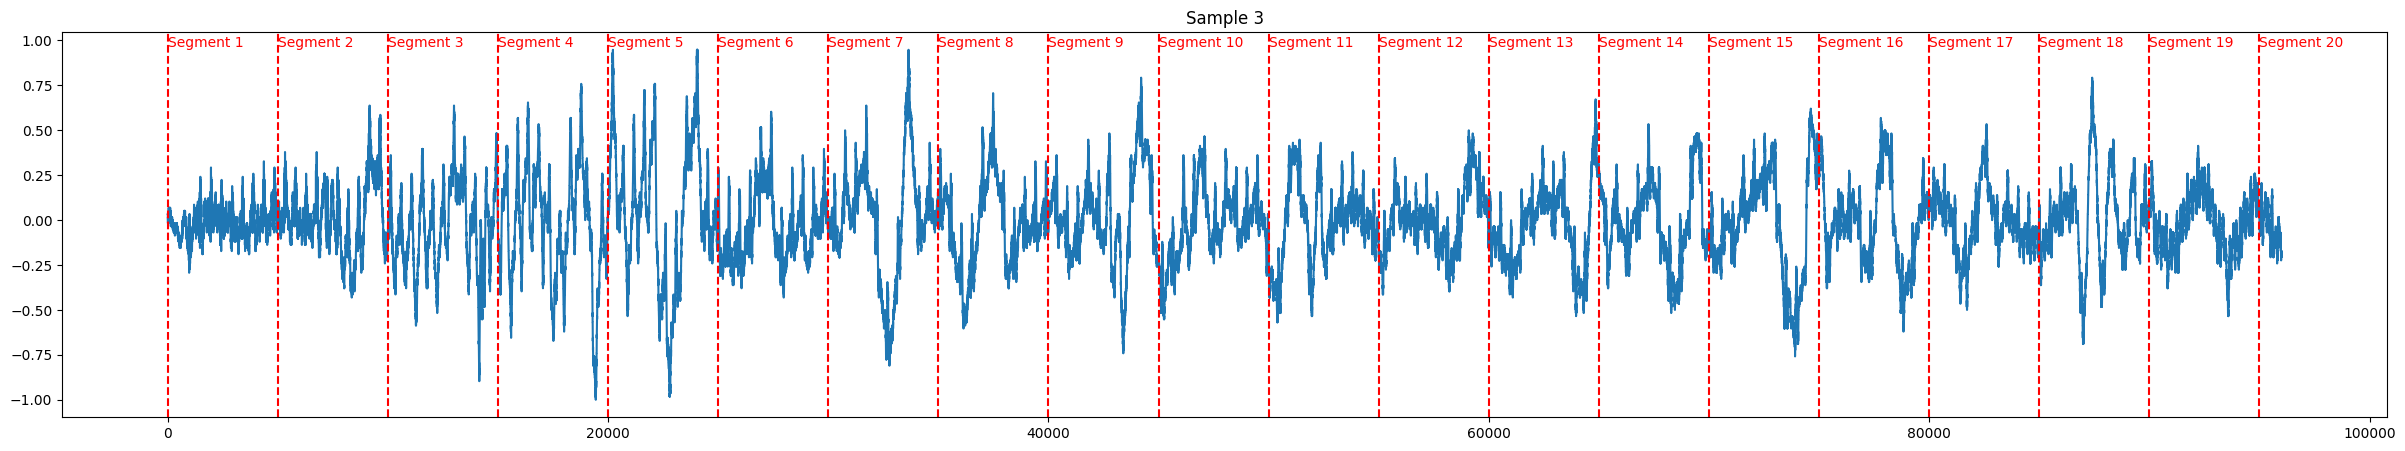

In [991]:
segment_size = 5000
sample_closing_0 = samples_closing[2]

sample_closing_0 = sample_closing_0 / np.max(np.abs(sample_closing_0)) #! normalization

num_segments = (len(sample_closing_0) // segment_size)+1

segments_sample_closing_0_spectra = []

for i in range(num_segments):
    segment = sample_closing_0[i*segment_size:(i+1)*segment_size]
    segment_spectrum = np.fft.rfft(segment)
    segment_amplitude = np.abs(segment_spectrum)
    segment_phase = np.angle(segment_spectrum)
    segment_frequency = np.fft.rfftfreq(len(segment), 1/SR)
    segment_series = pd.DataFrame({
        "Amplitude": segment_amplitude,
        "Phase": segment_phase
    }, index=pd.Index(segment_frequency, name="Frequency"))
    segments_sample_closing_0_spectra.append(segment_series)

plt.figure(figsize=(30, 5))
plt.plot(sample_closing_0)
plt.title(f'Sample 3')
for xc in range(0, len(sample_closing_0), segment_size):
    plt.axvline(x=xc, color='r', linestyle='--')
    plt.text(xc, max(sample_closing_0), f'Segment {xc // segment_size + 1}', rotation=0, verticalalignment='bottom', color='r')
plt.show()

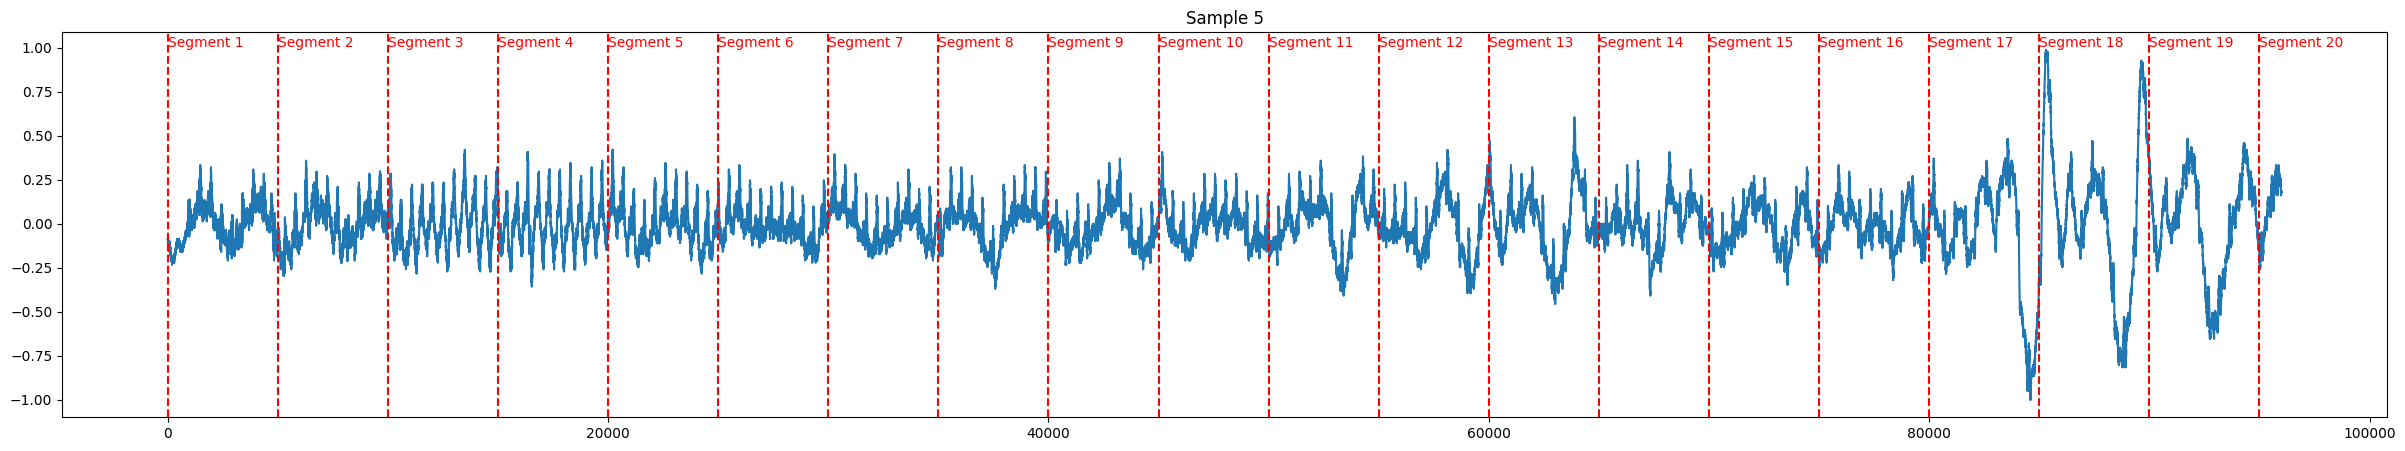

In [993]:
segment_size = 5000
sample_closing_0 = samples_closing[4]

sample_closing_0 = sample_closing_0 / np.max(np.abs(sample_closing_0)) #! normalization

num_segments = (len(sample_closing_0) // segment_size)+1

segments_sample_closing_0_spectra = []

for i in range(num_segments):
    segment = sample_closing_0[i*segment_size:(i+1)*segment_size]
    segment_spectrum = np.fft.rfft(segment)
    segment_amplitude = np.abs(segment_spectrum)
    segment_phase = np.angle(segment_spectrum)
    segment_frequency = np.fft.rfftfreq(len(segment), 1/SR)
    segment_series = pd.DataFrame({
        "Amplitude": segment_amplitude,
        "Phase": segment_phase
    }, index=pd.Index(segment_frequency, name="Frequency"))
    segments_sample_closing_0_spectra.append(segment_series)

plt.figure(figsize=(30, 5))
plt.plot(sample_closing_0)
plt.title(f'Sample 5')
for xc in range(0, len(sample_closing_0), segment_size):
    plt.axvline(x=xc, color='r', linestyle='--')
    plt.text(xc, max(sample_closing_0), f'Segment {xc // segment_size + 1}', rotation=0, verticalalignment='bottom', color='r')
plt.show()

segments 3,6,7 are fairly calm. here the frequency 398.4 was in the top 5

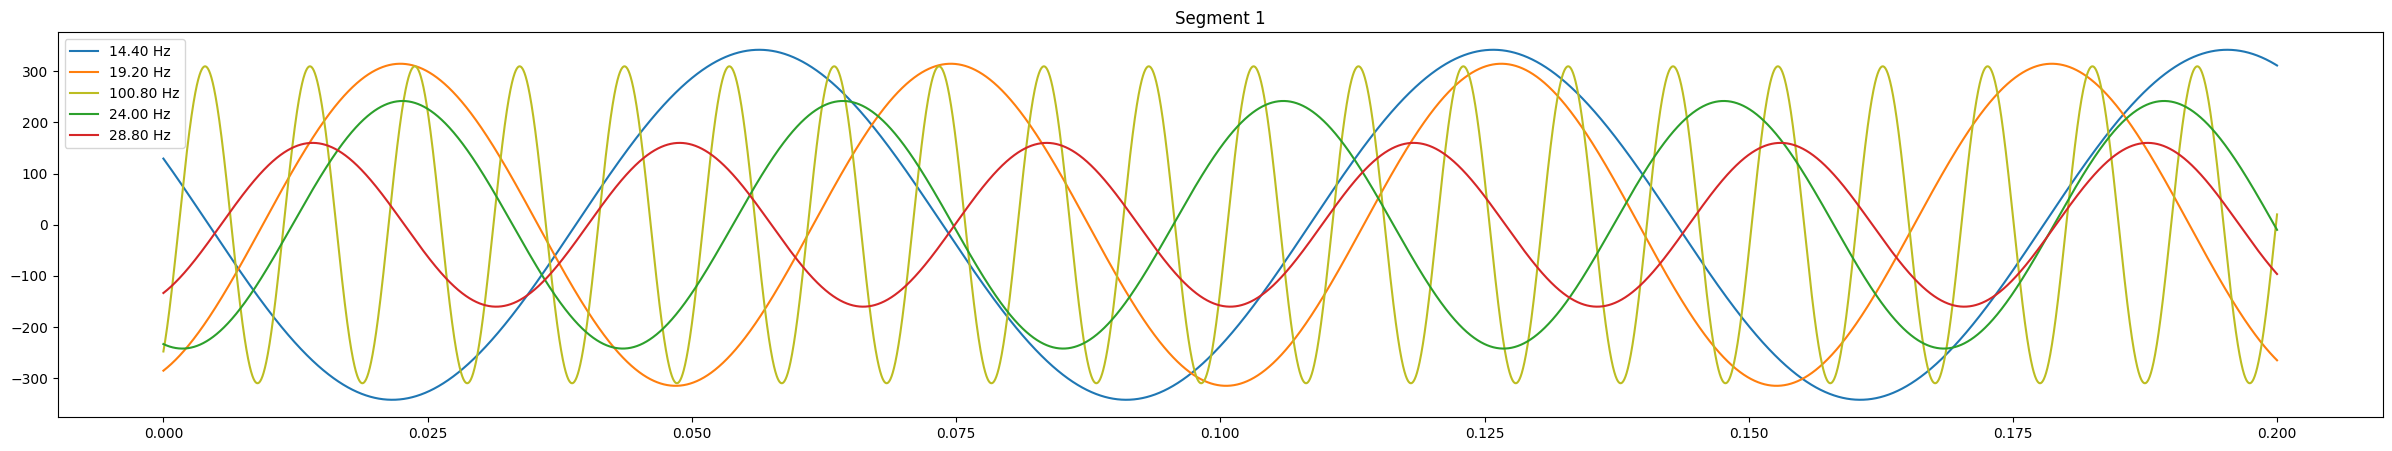

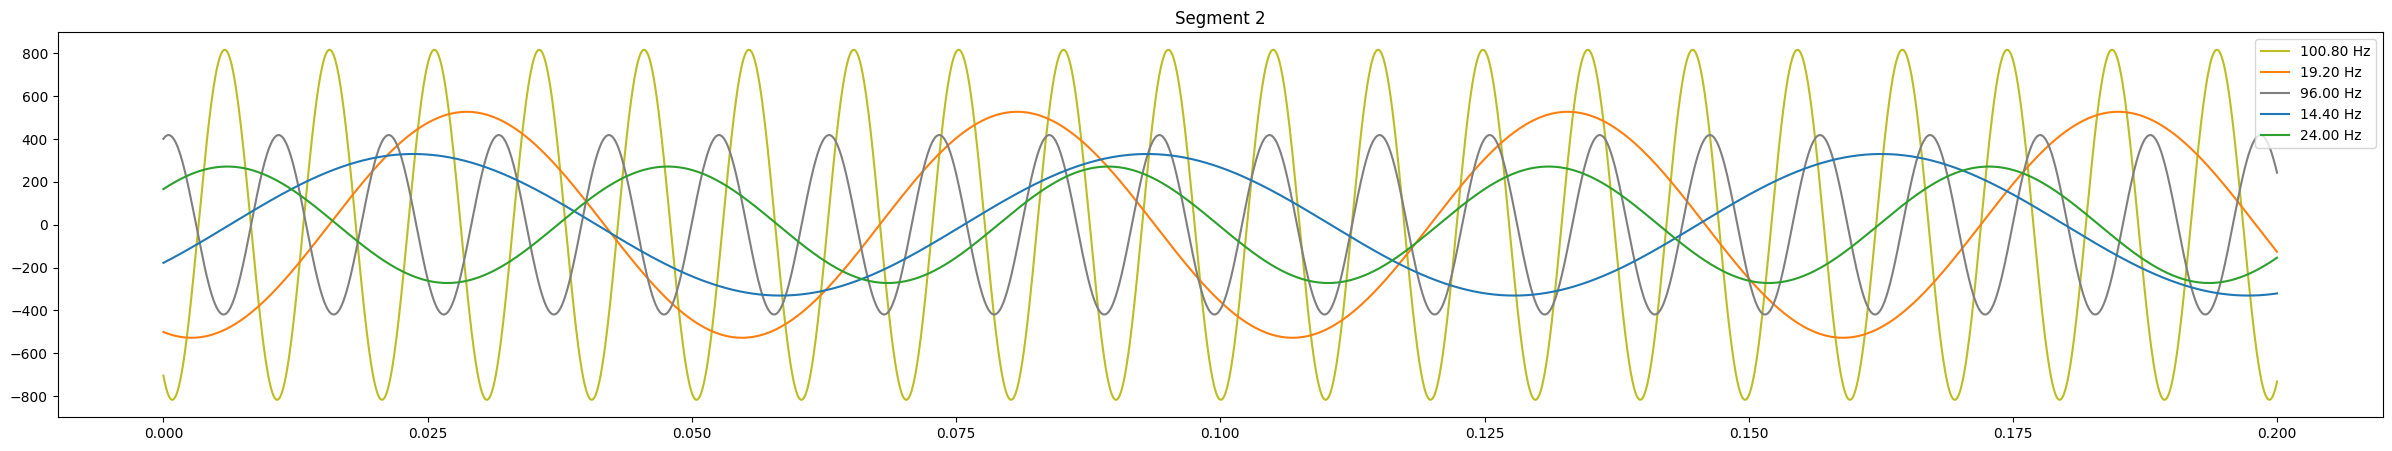

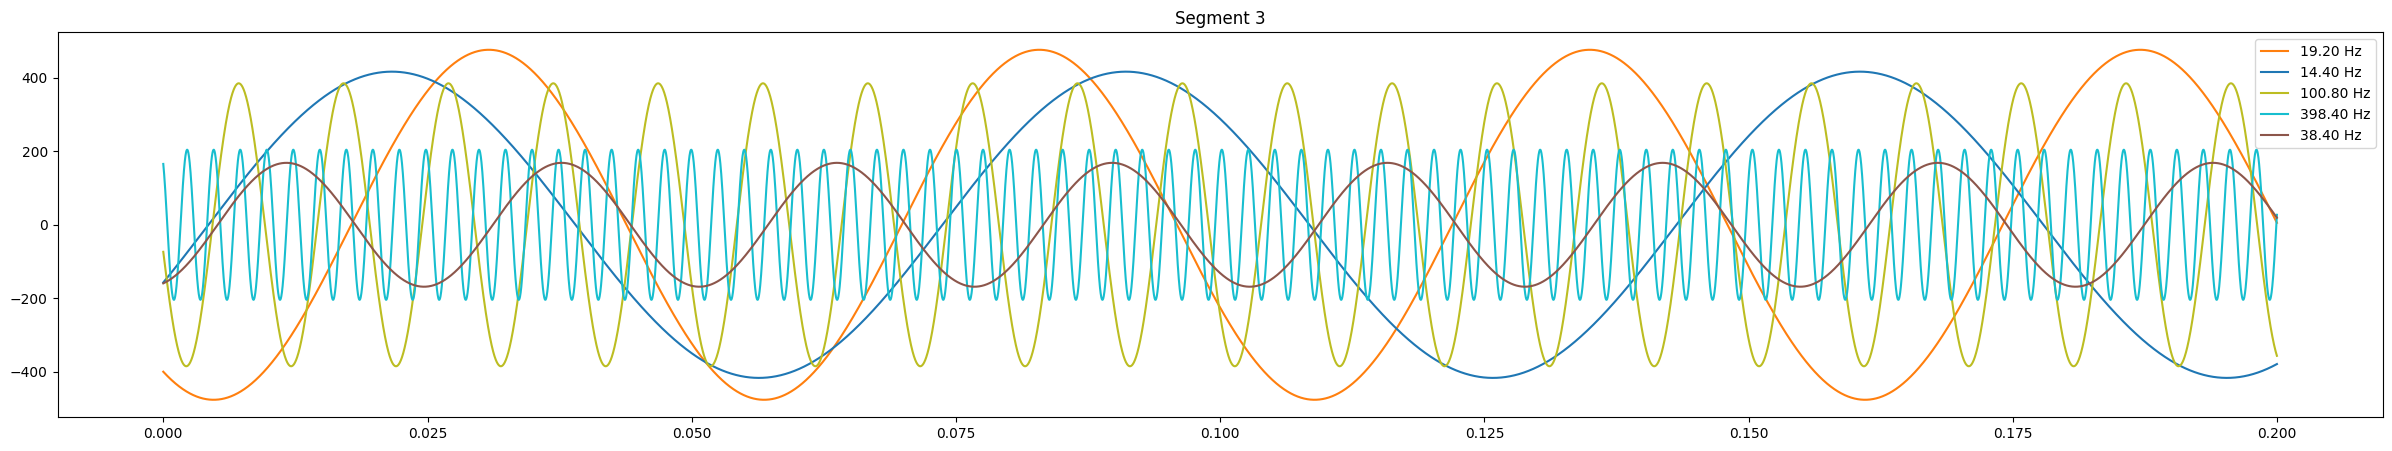

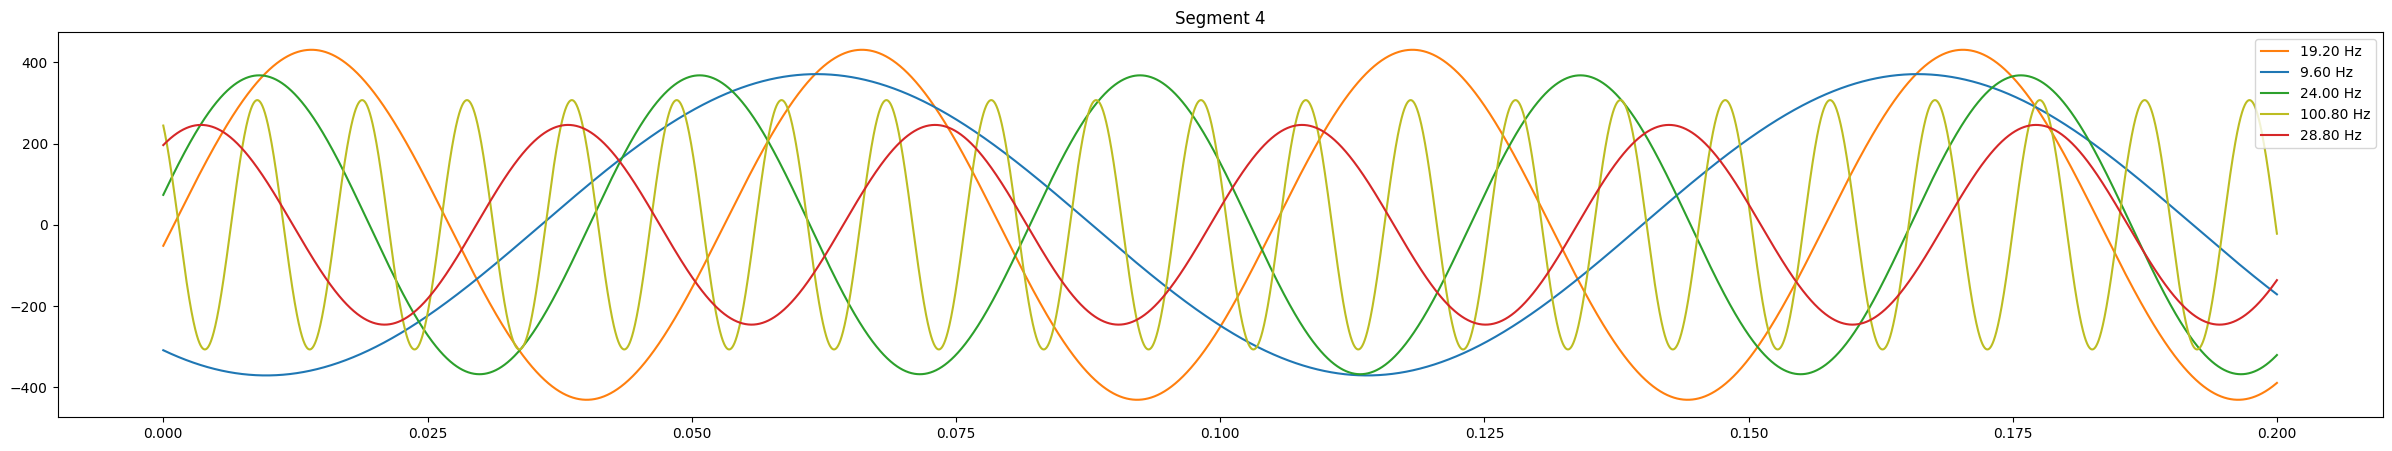

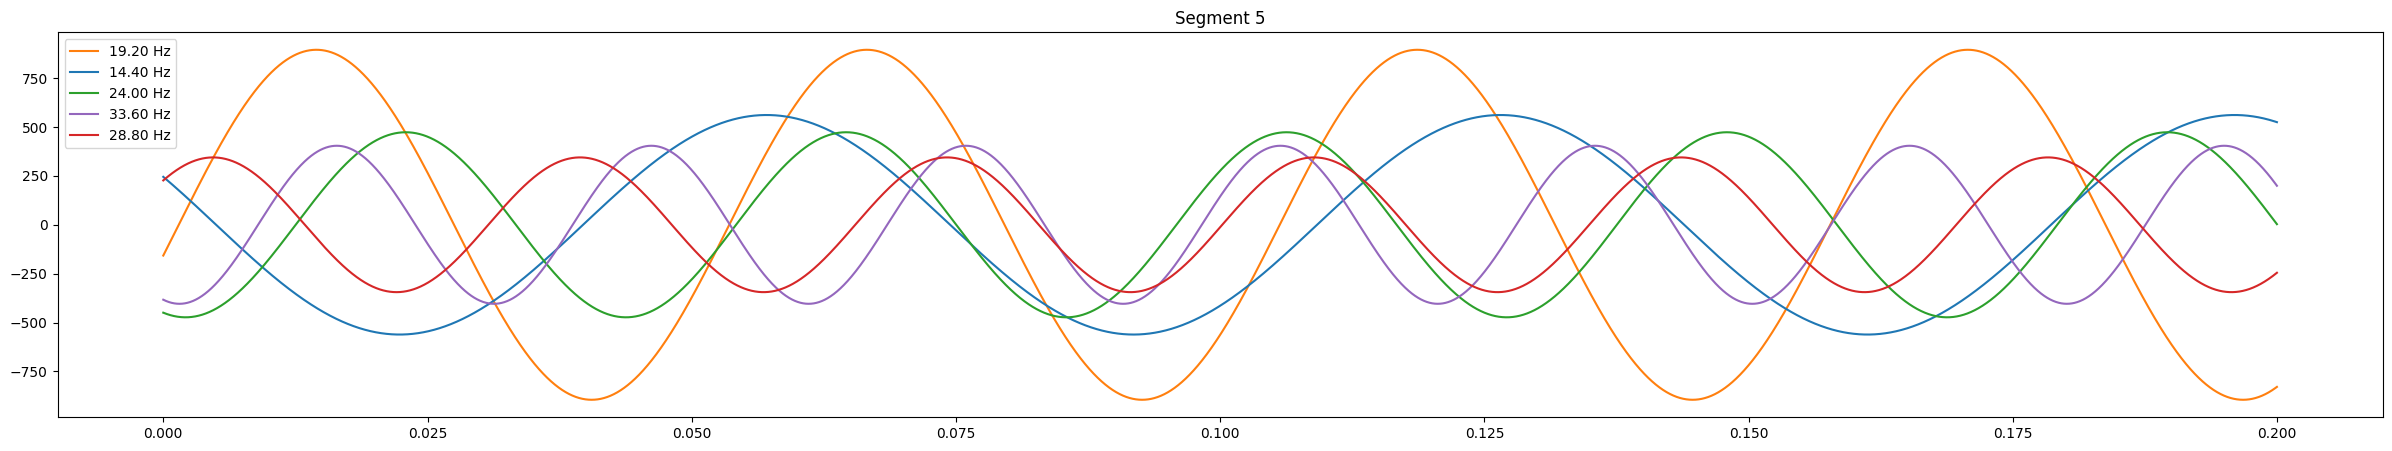

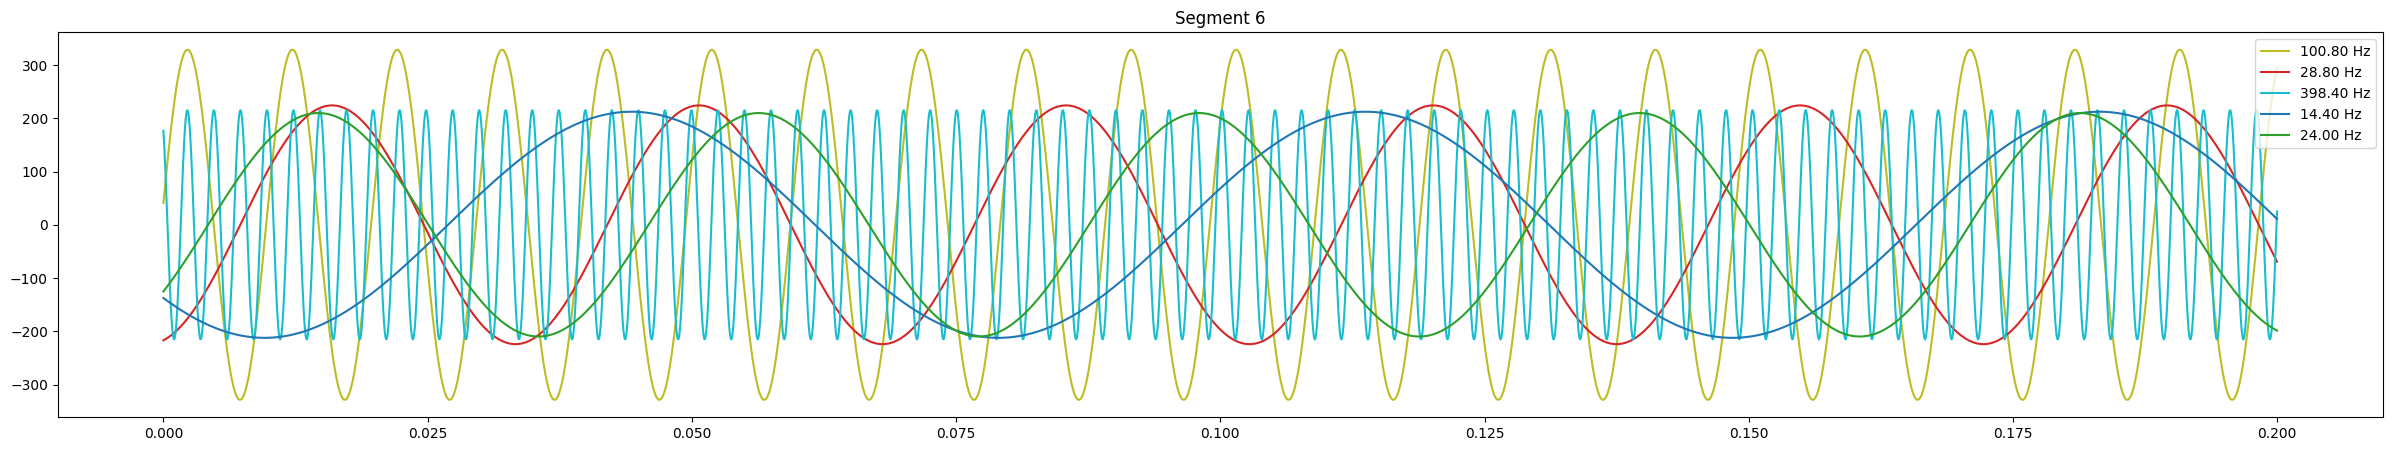

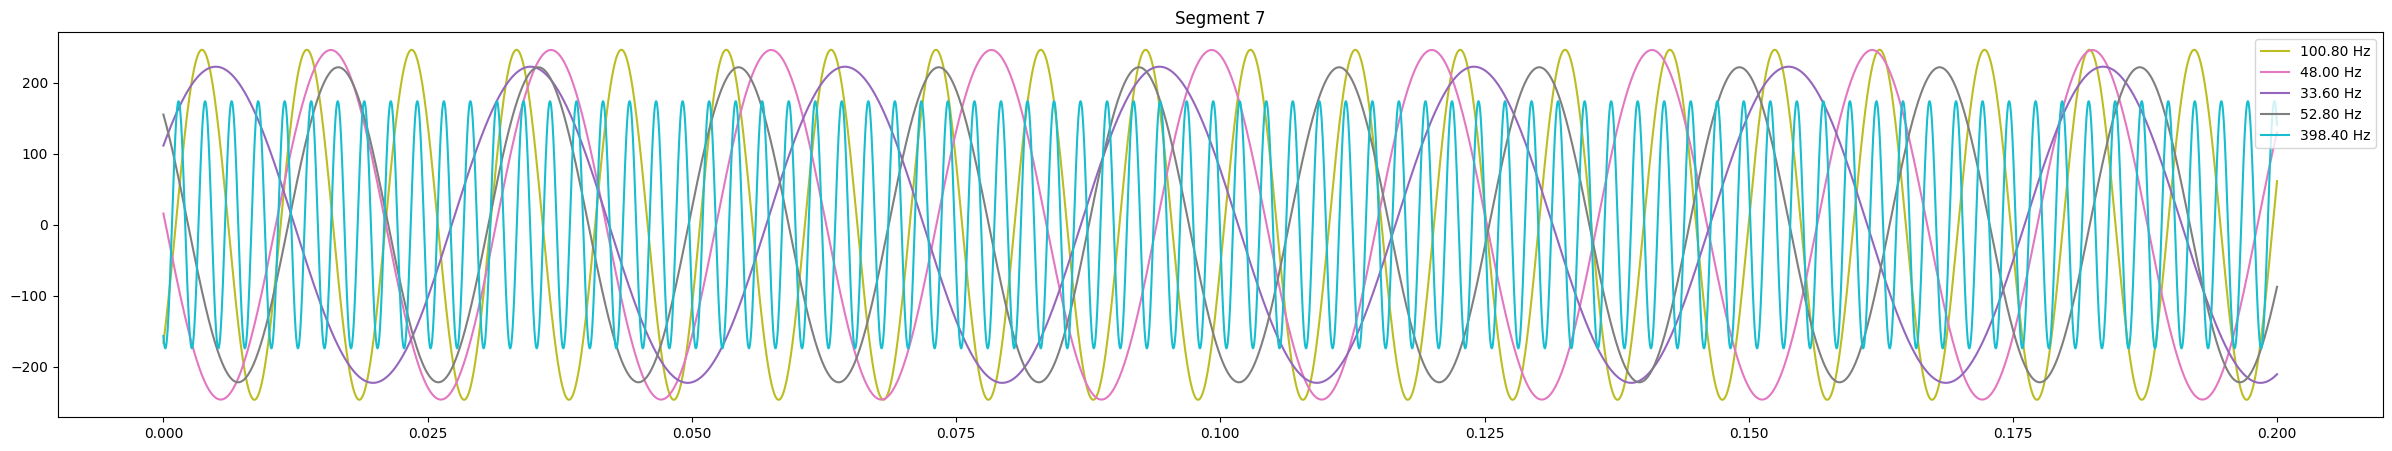

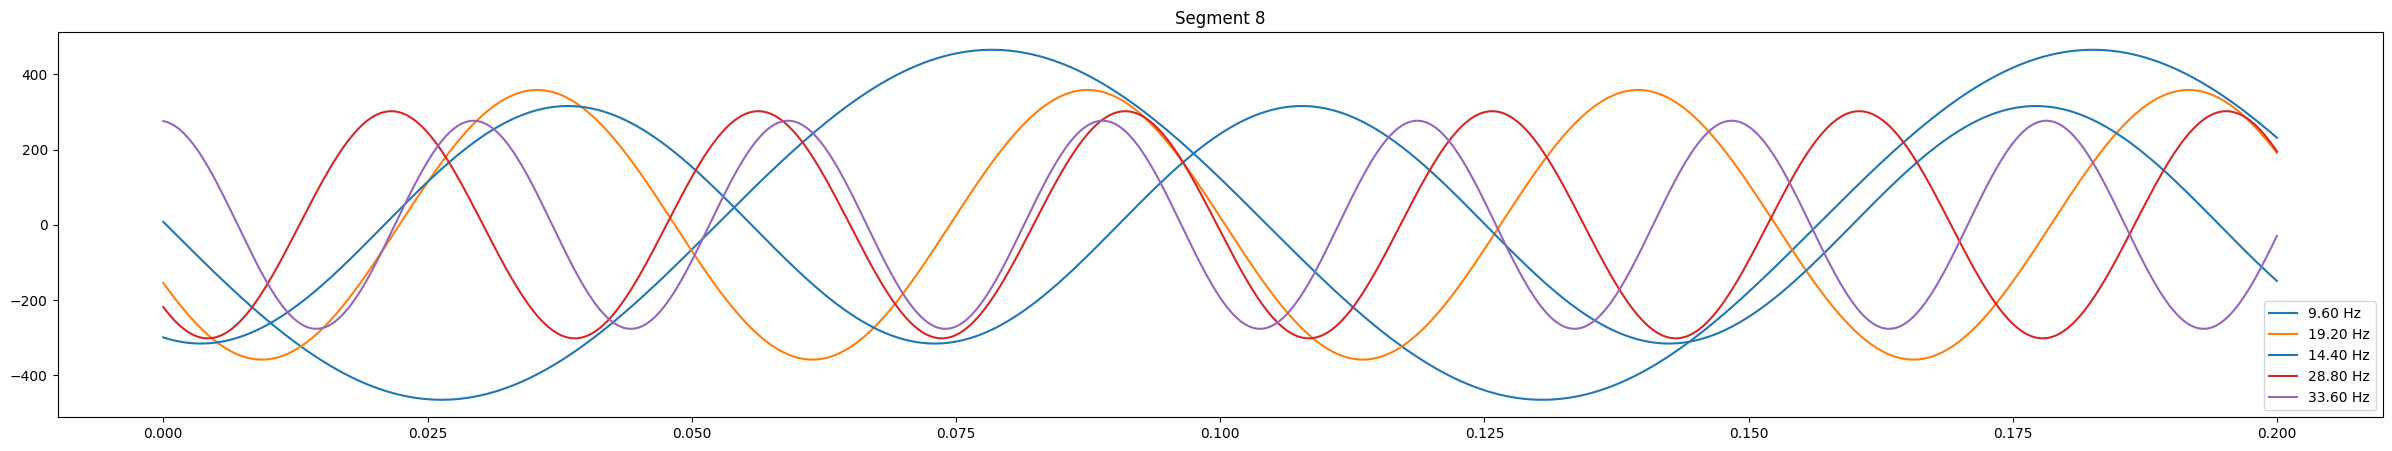

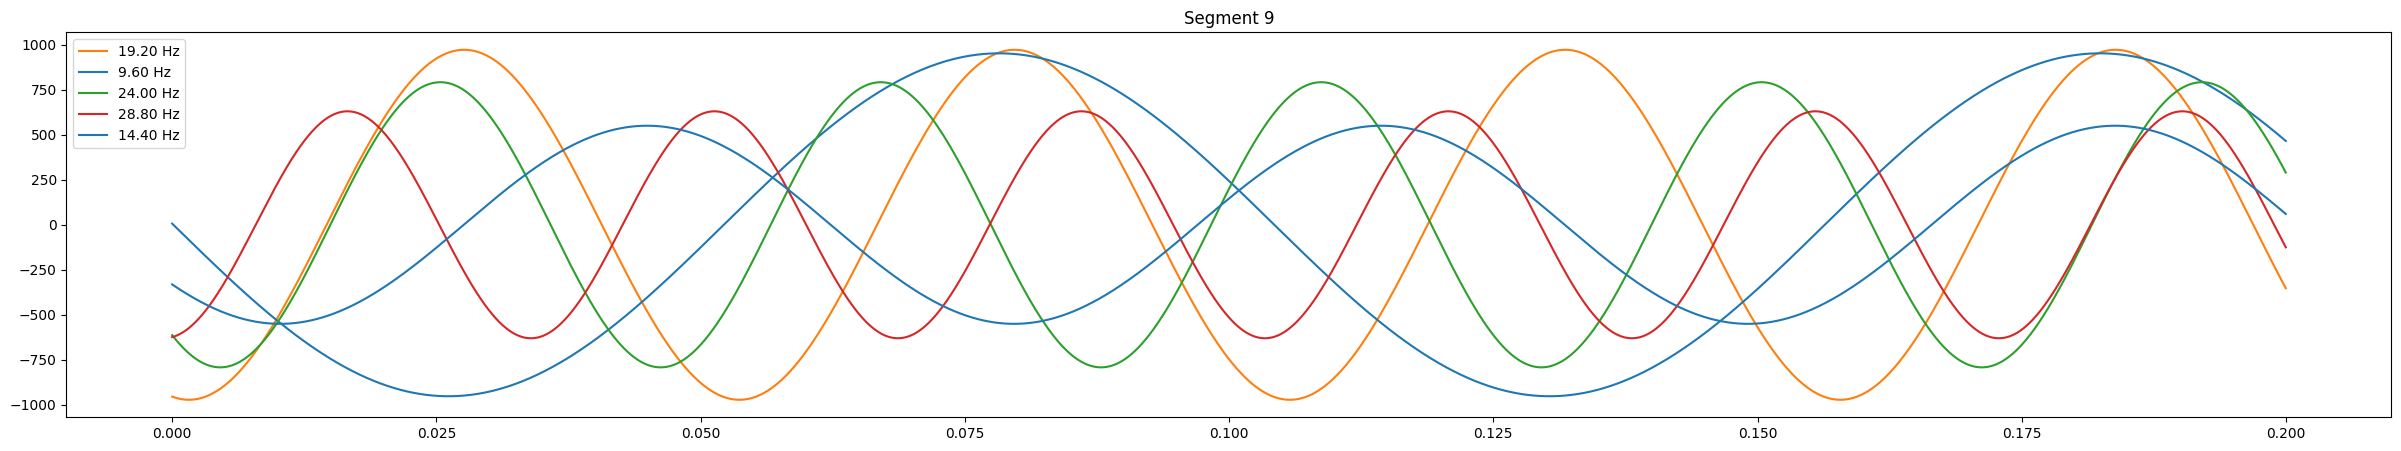

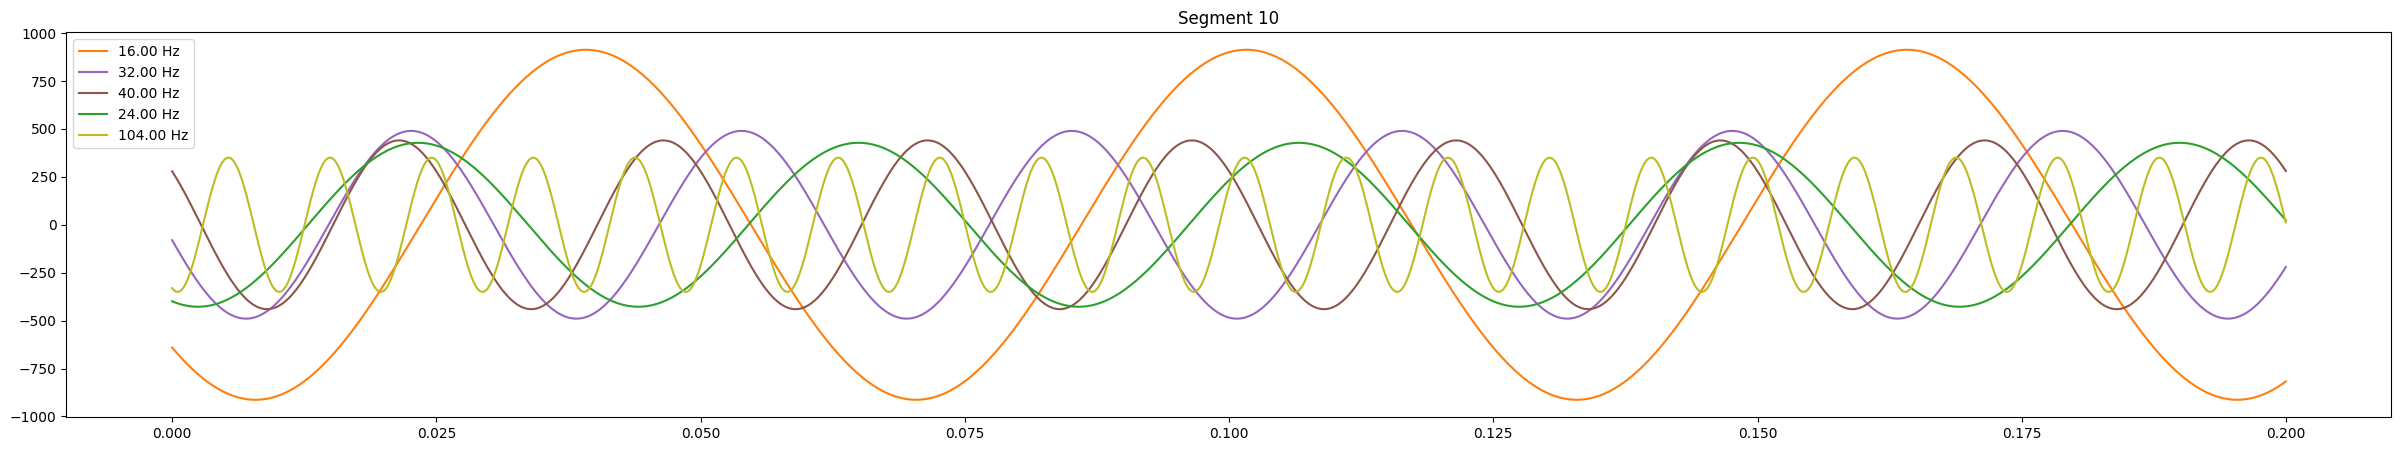

In [978]:
top_indices = []
top_n = 5
duration = 0.2  # seconds
t = np.linspace(0, duration, int(SR * duration), endpoint=False)
color_map = {}
unique_frequencies = set()
for segment in segments_sample_closing_0_spectra:
    top = segment['Amplitude'].nlargest(top_n).index
    top_indices.append(top)
    unique_frequencies.update(top)
cmap = plt.colormaps['tab10']
norm = Normalize(vmin=0, vmax=len(unique_frequencies))
for idx, freq in enumerate(sorted(unique_frequencies)):
    color_map[freq] = cmap(norm(idx))
for idx, top in enumerate(top_indices):
    plt.figure(figsize=(30, 5))
    for freq in top:
        amplitude = segments_sample_closing_0_spectra[idx].loc[freq, "Amplitude"]
        phase = segments_sample_closing_0_spectra[idx].loc[freq, "Phase"]
        sine_wave = amplitude * np.sin(2 * np.pi * freq * t + phase)
        plt.plot(t, sine_wave, label=f"{freq:.2f} Hz", color=color_map[freq])
    plt.title(f"Segment {idx+1}")
    plt.legend()
    plt.show()

In [981]:
top_indices = []
top_n = 10
unique_frequencies = set()

data = []

for segment in segments_sample_closing_0_spectra:    
    top = segment['Amplitude'].nlargest(top_n).index
    top_indices.append(top)
    unique_frequencies.update(top)

# Iterate over each segment and its frequencies in unique_frequencies
for segment_idx, segment in enumerate(segments_sample_closing_0_spectra):
    segment['Amplitude'] = segment['Amplitude'] / np.max(np.abs(segment['Amplitude'])) #! normalization
    for freq in unique_frequencies:
        if freq in segment.index:
            amplitude = segment.loc[freq, "Amplitude"]
            phase = segment.loc[freq, "Phase"]
            data.append({
                "Segment": segment_idx + 1,
                "Frequency": freq,
                "Amplitude": amplitude,
                "Phase": phase
            })

# Create a DataFrame from the collected data
all_frequencies_df = pd.DataFrame(data)

In [950]:
unique_frequencies_rounded = {round(freq, 2) for freq in unique_frequencies}
unique_frequencies_rounded

{0.0,
 4.8,
 9.6,
 14.4,
 19.2,
 24.0,
 28.8,
 33.6,
 38.4,
 43.2,
 48.0,
 52.8,
 57.6,
 91.2,
 96.0,
 100.8,
 105.6,
 201.6,
 297.6,
 302.4,
 398.4}

In [980]:
tolerance = 1e-6
all_frequencies_df[np.isclose(all_frequencies_df['Frequency'], 398.4, atol=tolerance)]

Segment  Frequency  Amplitude     Phase
4          1      398.4   0.344733 -1.198456
25         2      398.4   0.255485  0.418917
46         3      398.4   0.428873  2.196169
67         4      398.4   0.358989 -1.930719
88         5      398.4   0.228765  0.144767
109        6      398.4   0.654406  2.178834
130        7      398.4   0.705938 -2.021084
151        8      398.4   0.359202  0.062304
172        9      398.4   0.186130  2.152072

In [951]:
tolerance = 1e-6
all_frequencies_df[np.isclose(all_frequencies_df['Frequency'], 100.8, atol=tolerance)]

Segment  Frequency  Amplitude     Phase
19         1      100.8   0.905425 -0.926651
40         2      100.8   1.000000 -2.102252
61         3      100.8   0.808364 -2.949206
82         4      100.8   0.712344  2.221110
103        5      100.8   0.365849  0.983872
124        6      100.8   1.000000  0.124524
145        7      100.8   1.000000 -0.740251
166        8      100.8   0.365229 -1.294304
187        9      100.8   0.194795 -2.517201

In [952]:
all_frequencies_df[np.isclose(all_frequencies_df['Frequency'], 14.4, atol=tolerance)]

Segment  Frequency  Amplitude     Phase
3          1       14.4   1.000000  2.753673
24         2       14.4   0.404475 -0.567725
45         3       14.4   0.874979 -0.386478
66         4       14.4   0.554928 -1.564471
87         5       14.4   0.627231  2.689564
108        6       14.4   0.646115 -2.436718
129        7       14.4   0.560682 -1.542846
150        8       14.4   0.678618 -1.892822
171        9       14.4   0.566067 -2.495295

In [953]:
all_frequencies_df[np.isclose(all_frequencies_df['Frequency'], 19.2, atol=tolerance)]

Segment  Frequency  Amplitude     Phase
5          1       19.2   0.920198 -1.133675
26         2       19.2   0.645629 -1.891919
47         3       19.2   1.000000 -2.144942
68         4       19.2   1.000000 -0.120269
89         5       19.2   1.000000 -0.176749
110        6       19.2   0.591359  3.140613
131        7       19.2   0.521532  0.262804
152        8       19.2   0.770309 -2.695824
173        9       19.2   1.000000 -1.762595

<Axes: xlabel='Frequency'>

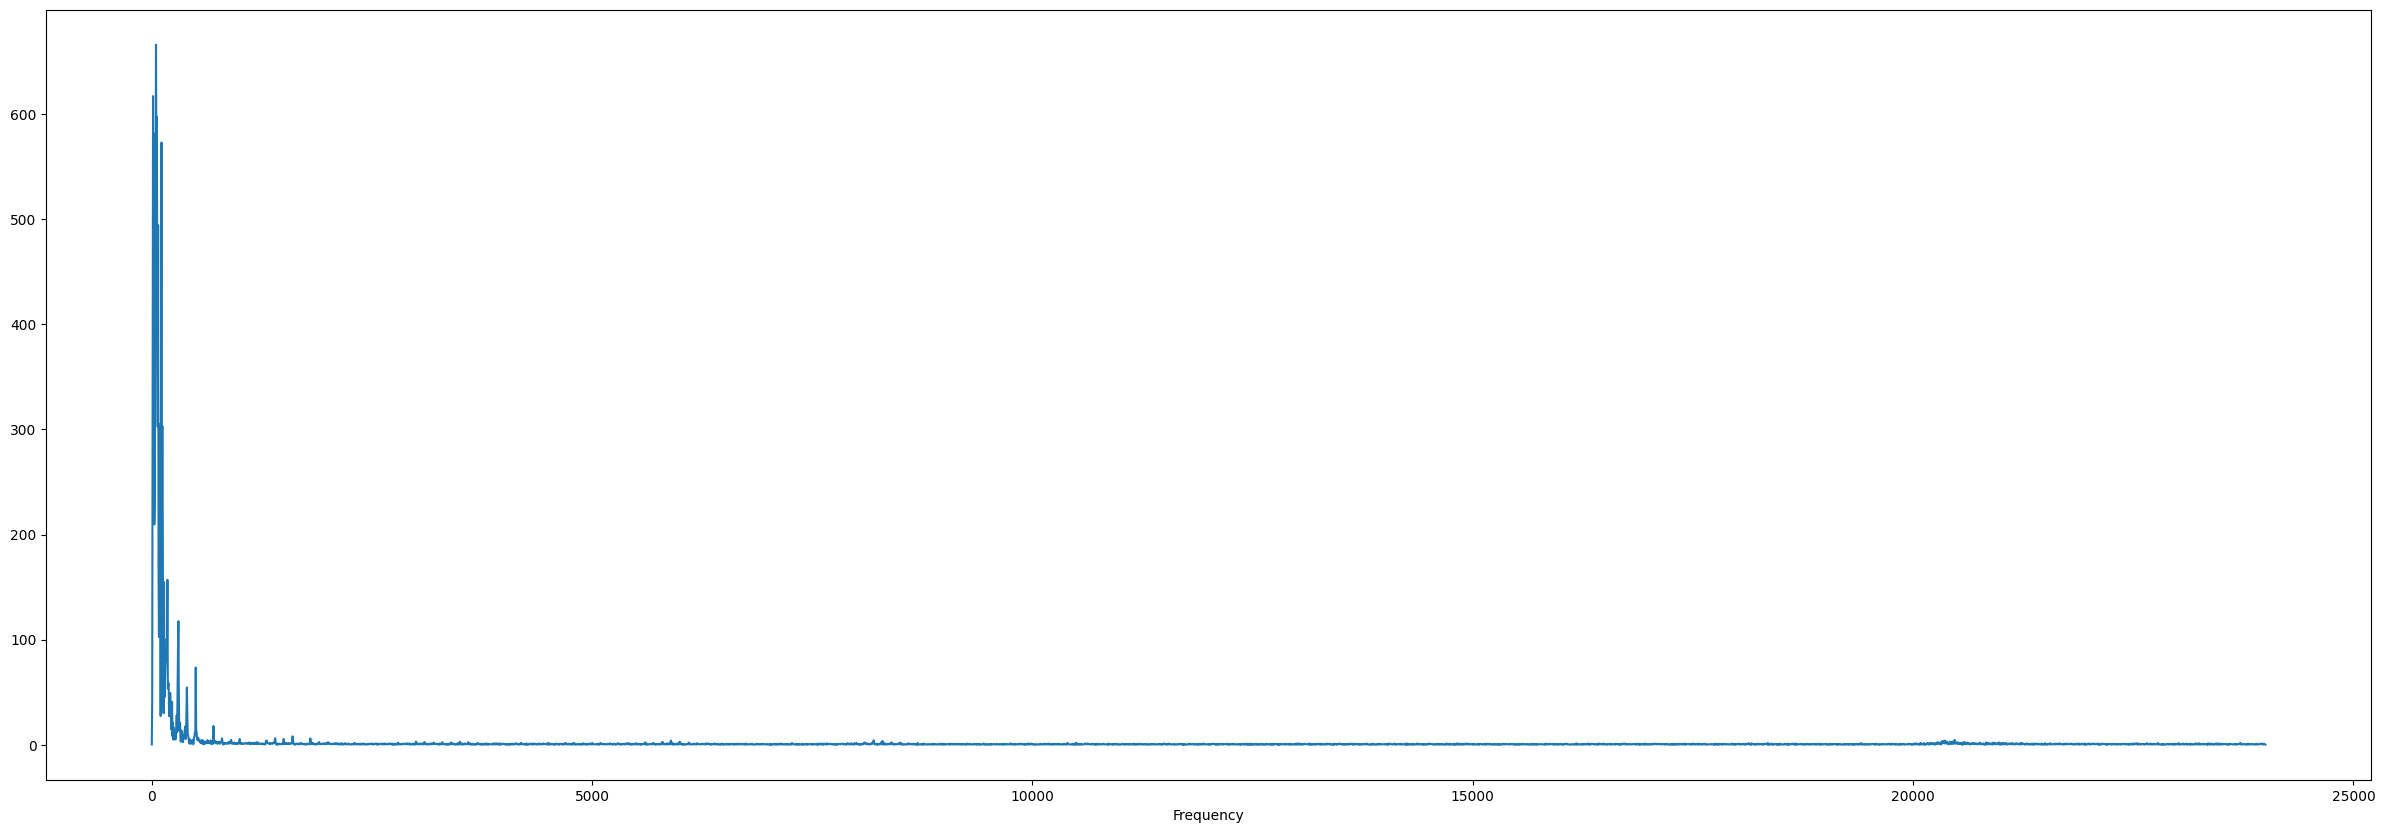

In [846]:
plt.figure(figsize=(30, 10))
segments_sample_closing_0_spectra[-1].Amplitude.plot()

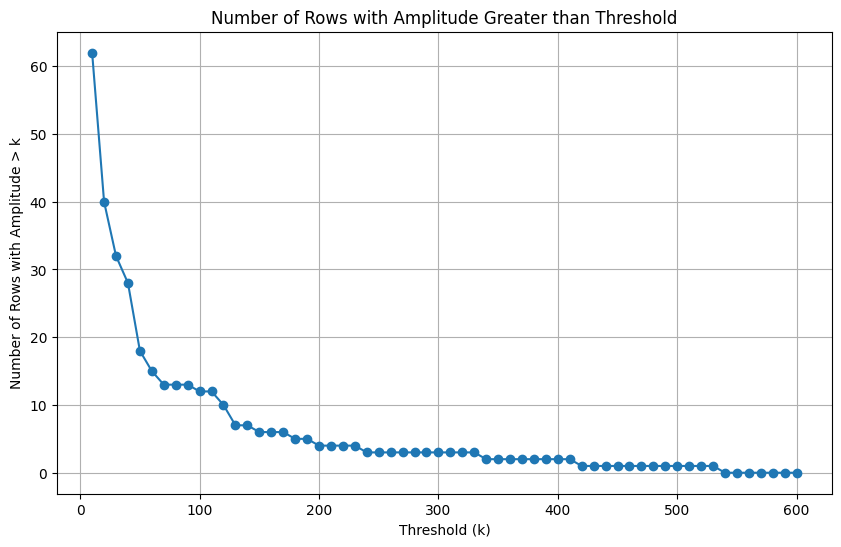

In [861]:
# segments_sample_closing_0_spectra[2][segments_sample_closing_0_spectra[2]['Amplitude'] > 5].shape[0]
k_values = np.arange(10, 601, 10)
counts = [segments_sample_closing_0_spectra[2][segments_sample_closing_0_spectra[2]['Amplitude'] > k].shape[0] for k in k_values]

plt.figure(figsize=(10, 6))
plt.plot(k_values, counts, marker='o')
plt.xlabel('Threshold (k)')
plt.ylabel('Number of Rows with Amplitude > k')
plt.title('Number of Rows with Amplitude Greater than Threshold')
plt.grid(True)
plt.show()

In [ ]:
samples_closing_spectra = []
for sample in samples_closing:
    sample_spectrum = np.fft.rfft(sample)
    sample_amplitude = np.abs(sample_spectrum)
    sample_phase = np.angle(sample_spectrum)
    sample_frequency = np.fft.rfftfreq(len(sample), 1/SR)
    sample_series = pd.DataFrame({
        "Amplitude": sample_amplitude,
        "Phase": sample_phase
    }, index=pd.Index(sample_frequency, name="Frequency"))
    samples_closing_spectra.append(sample_series)

In [1072]:
# Compute the FFT spectrum
Ains_spectrum = np.fft.rfft(Ains_norm)

# Extract amplitude (magnitude) and phase (angle)
Ains_amplitude = np.abs(Ains_spectrum)
Ains_phase = np.angle(Ains_spectrum)

# Compute frequency bins
Ains_frequency = np.fft.rfftfreq(len(Ains), 1/SR)

# Create a DataFrame with frequency, amplitude, and phase
Ains_series = pd.DataFrame({
    "Amplitude": Ains_amplitude,
    "Phase": Ains_phase
}, index=pd.Index(Ains_frequency, name="Frequency"))
Ains_series

Amplitude     Phase
Frequency                          
0.000000      4337.937500  3.141593
0.344828       101.211224  0.894201
0.689655       229.490781  1.593021
1.034483        45.744561 -0.345539
1.379310       135.252834 -1.147511
...                   ...       ...
23998.620690    10.617820  1.099085
23998.965517    16.098982 -2.405321
23999.310345     9.971789  1.143164
23999.655172    10.673901 -0.173511
24000.000000   146.687500  0.000000

[69601 rows x 2 columns]

<Axes: title={'center': 'Frequency Spectrum'}, xlabel='Frequency (Hz)', ylabel='Amplitude'>

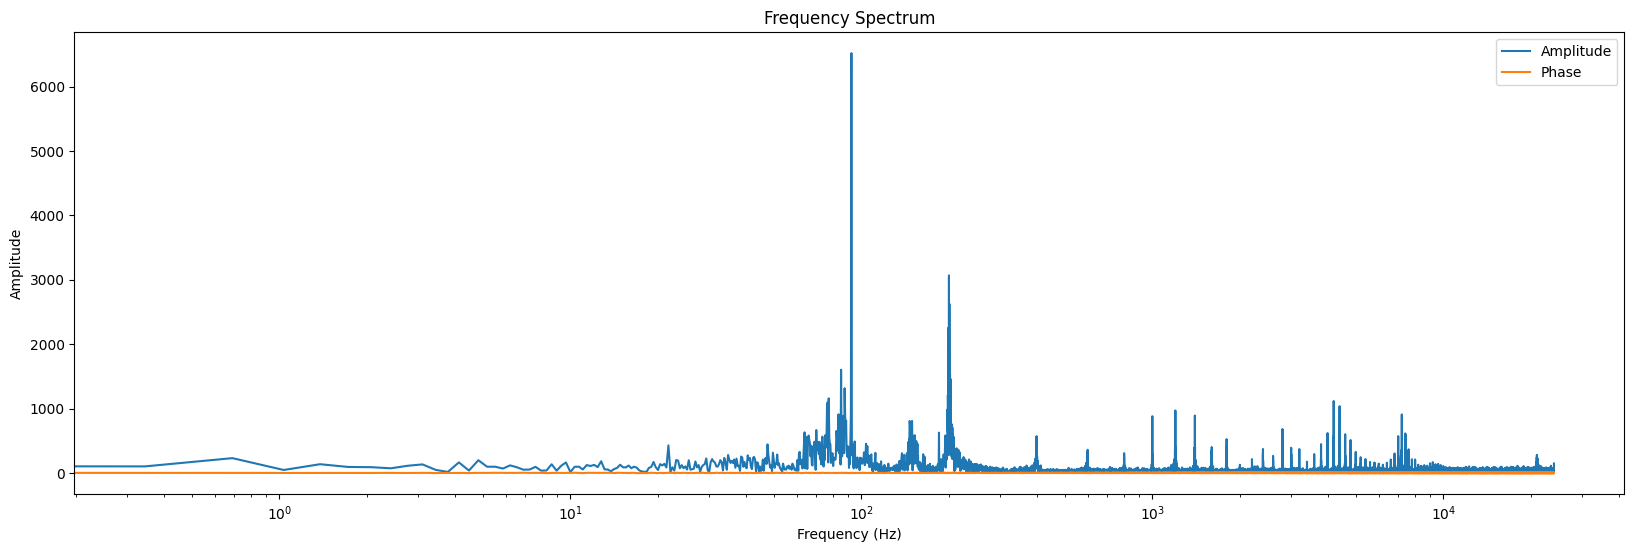

In [1074]:
Ains_series.plot(title="Frequency Spectrum", xlabel="Frequency (Hz)", ylabel="Amplitude", logy=False, logx=True, figsize=(20, 6))